<a href="https://colab.research.google.com/github/darrenjhsu/birdid/blob/master/Bird_ID_many_species_CNN_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
datapath = '/content/gdrive/My Drive/Bird_ID_project/nabirds'

In [0]:
from __future__ import absolute_import, division, print_function
import os
!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
keras = tf.keras

In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing import image

Using TensorFlow backend.


In [0]:
def split_data(X, y, num_classes):

    # le = LabelEncoder()
    # y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2200)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    #X_test, X_val = X_test[:-4000], X_test[-4000:]
    #y_test, y_val = y_test[:-4000], y_test[-4000:]

    # convert class vectors to binary class matrices
    Y_train = to_categorical(y_train, num_classes)
    #Y_val = to_categorical(y_val, num_classes)
    Y_test = to_categorical(y_test, num_classes)
    

    #print('\nX_train shape: {}\n y_train shape: {}\n X_val shape: {}\n y_val shape: {}\n X_test shape: {}\n y_test shape: {}'.format(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))
    print('\nX_train shape: {}\n y_train shape: {}\n X_test shape: {}\n y_test shape: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    print('Y_train shape: {}\n Y_test shape: {}'.format(Y_train.shape, Y_test.shape))

    return X_train, X_test, Y_train, Y_test, y_test

In [0]:
if __name__ == '__main__':
    X = np.load(datapath + '/data/X_30.npy')
    y = np.load(datapath + '/data/y_30.npy')
    L = np.load(datapath + '/data/L_30.npy')
    
    
    

NameError: ignored

In [0]:
X_train, X_test, Y_train, Y_test, y_test = split_data(X, y, 25)


X_train shape: (2250, 224, 224, 3)
 y_train shape: (2250,)
 X_test shape: (750, 224, 224, 3)
 y_test shape: (750,)
Y_train shape: (2250, 25)
 Y_test shape: (750, 25)


In [0]:
y

array([ 0,  0,  0, ..., 24, 24, 24])

In [0]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
feature_batch = base_model(X_train)

In [0]:
print(feature_batch.shape)

In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [0]:
feature_batch_average = global_average_layer(feature_batch)

In [0]:
print(feature_batch_average.shape)

In [0]:
prediction_layer = keras.layers.Dense(25,activation='softmax')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [0]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [0]:
base_learning_rate = 0.0001

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                32025     
Total params: 2,290,009
Trainable params: 32,025
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
def _image_generator(X_train, Y_train):
    train_datagen = image.ImageDataGenerator(
            rotation_range=0,
            width_shift_range=0.0,
            height_shift_range=0.0,
            horizontal_flip=True)
    train_datagen.fit(X_train, seed=1919)
    return train_datagen

def fit_model(model, X_train, X_test, y_train, y_test, batch_size=32, epochs=10):
    generator = _image_generator(X_train, y_train)
    # Change learning rate when learning plateaus
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
              patience=4, min_lr=0.00001)

    # Stop model once it stops improving to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

    # put all callback functions in a list
    callbacks_list = [early_stop, reduce_lr]
    callbacks_list = [reduce_lr]
    
    history = model.fit(
        generator.flow(X_train, Y_train, batch_size=batch_size),
        steps_per_epoch=(X_train.shape[0] // batch_size),
        epochs=epochs,
        callbacks=None
        )
    score = model.evaluate(X_test, y_test, verbose=1)
    probs = model.predict(X_test, batch_size=batch_size)
    return model, score, probs, history

In [0]:
fit_model, score, probs, history = fit_model(model, X_train, X_test, Y_train, Y_test, batch_size=32, epochs=30)


Epoch 1/30
70/70 [==============================] - 16s 228ms/step - loss: 0.1678 - accuracy: 0.9600
Epoch 2/30
70/70 [==============================] - 8s 108ms/step - loss: 0.1503 - accuracy: 0.9600
Epoch 3/30
70/70 [==============================] - 8s 108ms/step - loss: 0.1354 - accuracy: 0.9601
Epoch 4/30
70/70 [==============================] - 8s 108ms/step - loss: 0.1216 - accuracy: 0.9604
Epoch 5/30
70/70 [==============================] - 8s 109ms/step - loss: 0.1104 - accuracy: 0.9614
Epoch 6/30
70/70 [==============================] - 8s 109ms/step - loss: 0.0997 - accuracy: 0.9637
Epoch 7/30
70/70 [==============================] - 8s 110ms/step - loss: 0.0914 - accuracy: 0.9666
Epoch 8/30
70/70 [==============================] - 8s 108ms/step - loss: 0.0828 - accuracy: 0.9695
Epoch 9/30
70/70 [==============================] - 8s 108ms/step - loss: 0.0760 - accuracy: 0.9718
Epoch 10/30
70/70 [==============================] - 8s 109ms/step - loss: 0.0709 - accuracy: 0.974

Prediction: 12 (Northern_Harrier_(Female,_immature))
Actual: 12 (Northern_Harrier_(Female,_immature))


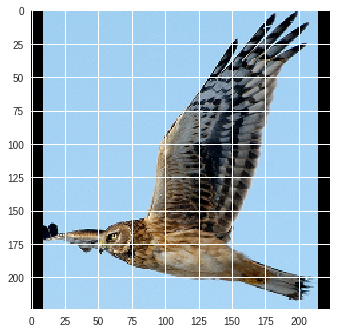

Prediction: 20 (Cooper's_Hawk_(Immature))
Actual: 20 (Cooper's_Hawk_(Immature))


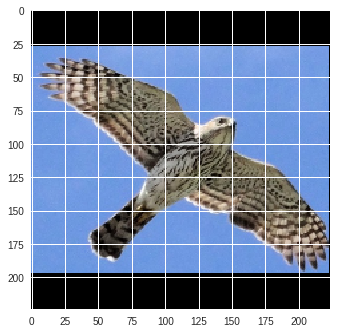

Prediction: 3 (Western_Meadowlark)
Actual: 3 (Western_Meadowlark)


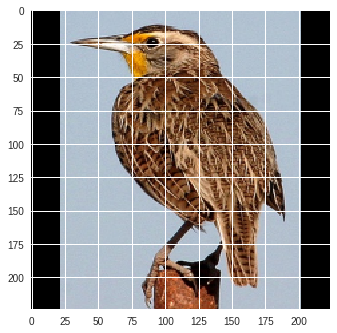

Prediction: 22 (Tufted_Titmouse)
Actual: 22 (Tufted_Titmouse)


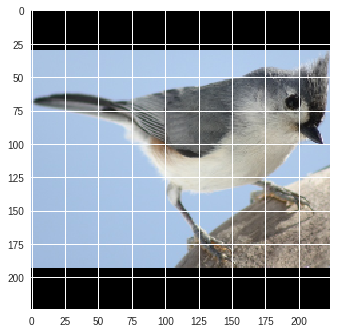

Prediction: 6 (Northern_Cardinal_(Female/Juvenile))
Actual: 6 (Northern_Cardinal_(Female/Juvenile))


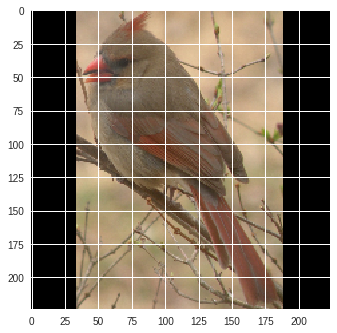

Prediction: 13 (Northern_Mockingbird)
Actual: 13 (Northern_Mockingbird)


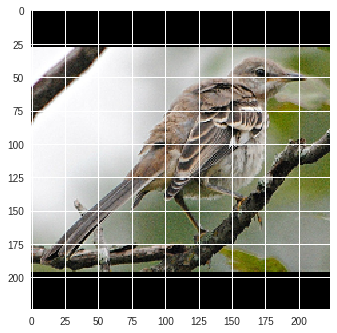

Prediction: 1 (Steller's_Jay)
Actual: 1 (Steller's_Jay)


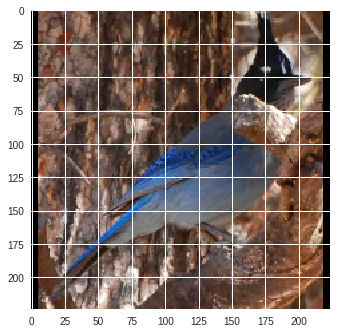

Prediction: 18 (Bushtit)
Actual: 18 (Bushtit)


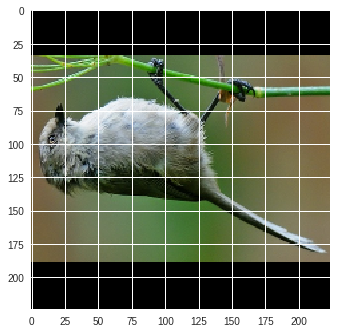

Prediction: 3 (Western_Meadowlark)
Actual: 3 (Western_Meadowlark)


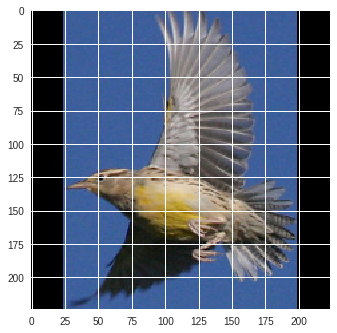

Prediction: 23 (Great-tailed_Grackle)
Actual: 23 (Great-tailed_Grackle)


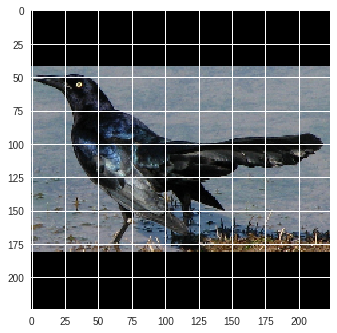

Prediction: 17 (American_Kestrel_(Adult_male))
Actual: 17 (American_Kestrel_(Adult_male))


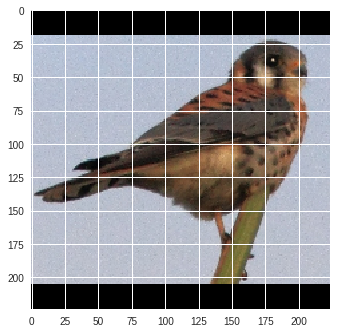

Prediction: 24 (Townsend's_Warbler)
Actual: 8 (Black-throated_Green_Warbler)


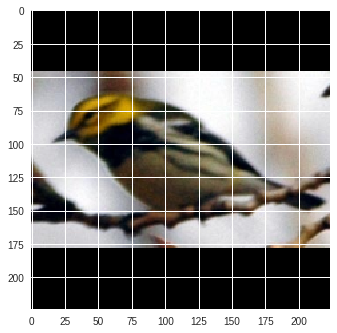

Prediction: 11 (Wilson's_Warbler)
Actual: 11 (Wilson's_Warbler)


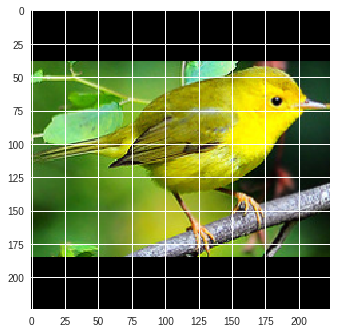

Prediction: 8 (Black-throated_Green_Warbler)
Actual: 8 (Black-throated_Green_Warbler)


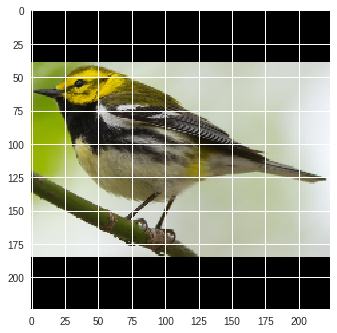

Prediction: 8 (Black-throated_Green_Warbler)
Actual: 8 (Black-throated_Green_Warbler)


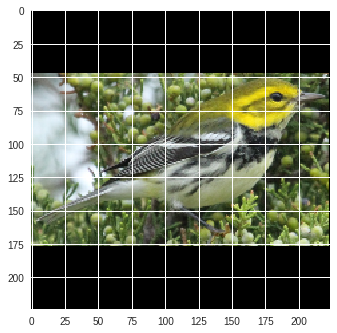

Prediction: 11 (Wilson's_Warbler)
Actual: 11 (Wilson's_Warbler)


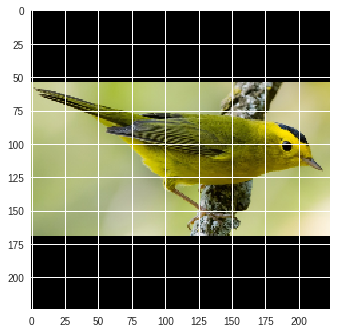

Prediction: 1 (Steller's_Jay)
Actual: 1 (Steller's_Jay)


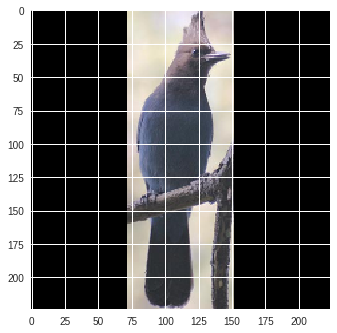

Prediction: 18 (Bushtit)
Actual: 15 (Hermit_Thrush)


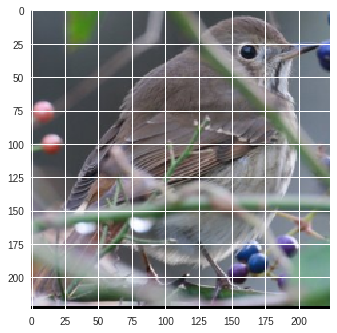

Prediction: 18 (Bushtit)
Actual: 16 (Prairie_Warbler)


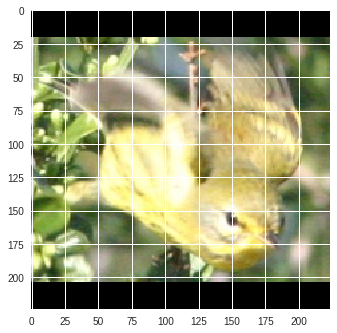

Prediction: 13 (Northern_Mockingbird)
Actual: 13 (Northern_Mockingbird)


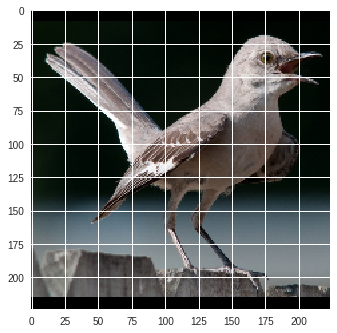

Prediction: 12 (Northern_Harrier_(Female,_immature))
Actual: 12 (Northern_Harrier_(Female,_immature))


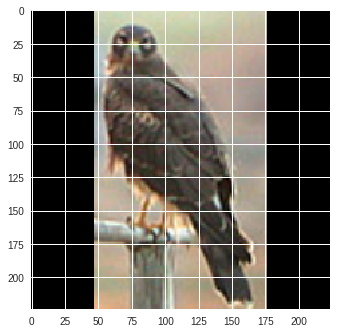

Prediction: 13 (Northern_Mockingbird)
Actual: 0 (Red-eyed_Vireo)


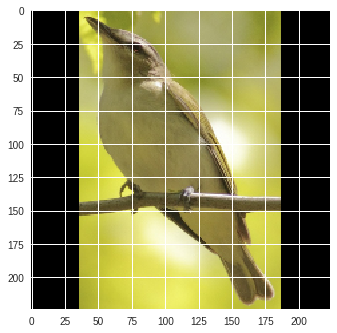

Prediction: 1 (Steller's_Jay)
Actual: 6 (Northern_Cardinal_(Female/Juvenile))


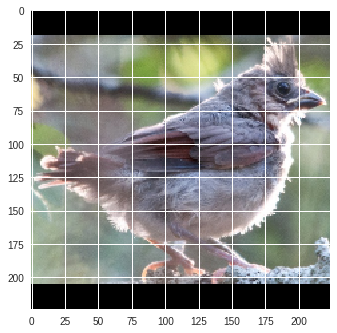

Prediction: 24 (Townsend's_Warbler)
Actual: 16 (Prairie_Warbler)


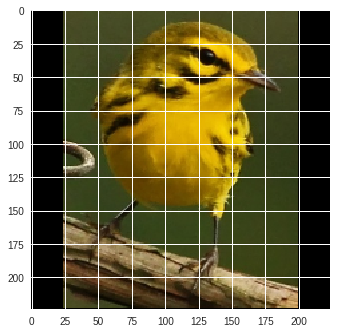

Prediction: 17 (American_Kestrel_(Adult_male))
Actual: 17 (American_Kestrel_(Adult_male))


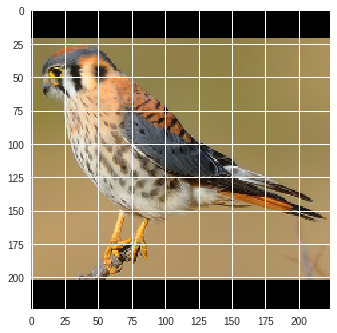

Prediction: 5 (House_Finch_(Adult_Male))
Actual: 5 (House_Finch_(Adult_Male))


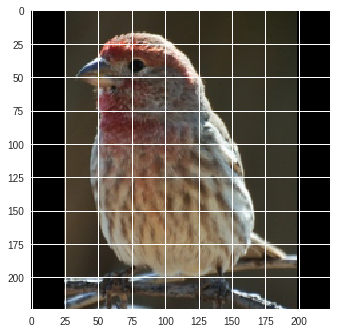

Prediction: 9 (Brown-headed_Cowbird_(Male))
Actual: 9 (Brown-headed_Cowbird_(Male))


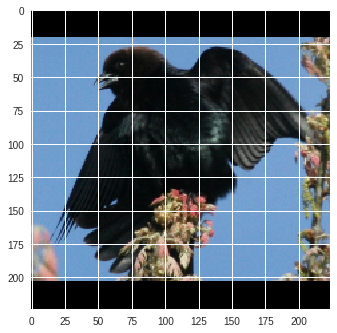

Prediction: 23 (Great-tailed_Grackle)
Actual: 4 (Gray_Catbird)


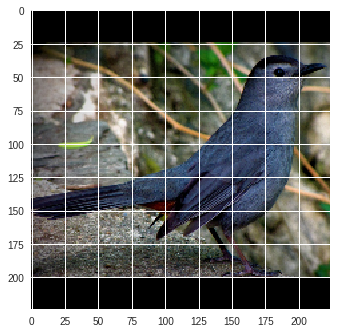

Prediction: 19 (Mourning_Dove)
Actual: 19 (Mourning_Dove)


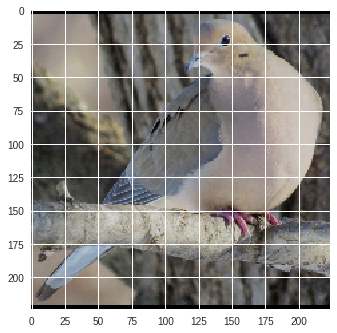

Prediction: 13 (Northern_Mockingbird)
Actual: 18 (Bushtit)


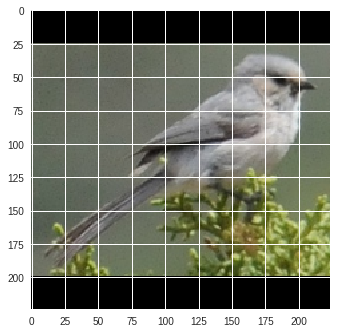

Prediction: 20 (Cooper's_Hawk_(Immature))
Actual: 12 (Northern_Harrier_(Female,_immature))


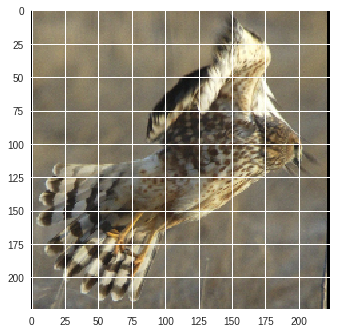

Prediction: 24 (Townsend's_Warbler)
Actual: 16 (Prairie_Warbler)


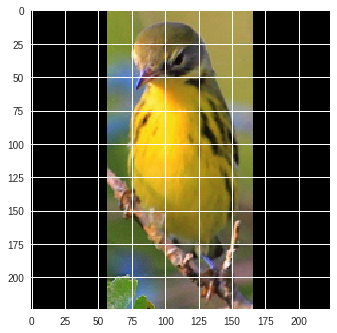

Prediction: 20 (Cooper's_Hawk_(Immature))
Actual: 12 (Northern_Harrier_(Female,_immature))


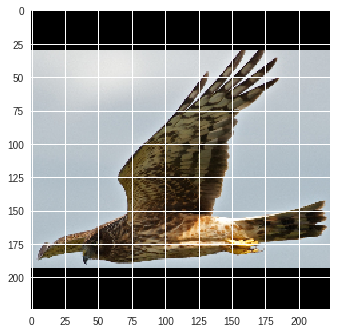

Prediction: 24 (Townsend's_Warbler)
Actual: 24 (Townsend's_Warbler)


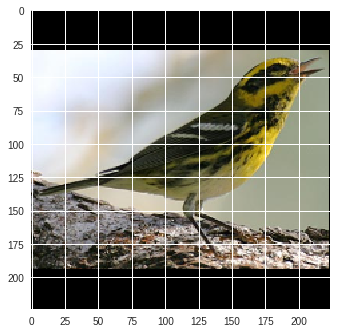

Prediction: 6 (Northern_Cardinal_(Female/Juvenile))
Actual: 6 (Northern_Cardinal_(Female/Juvenile))


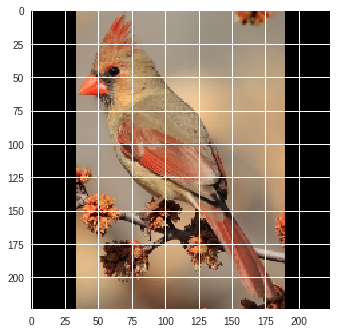

Prediction: 4 (Gray_Catbird)
Actual: 4 (Gray_Catbird)


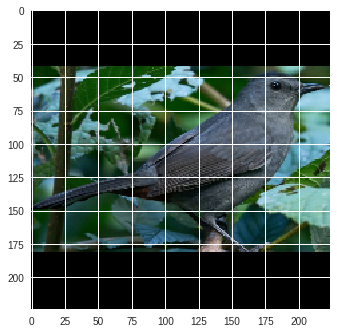

Prediction: 20 (Cooper's_Hawk_(Immature))
Actual: 20 (Cooper's_Hawk_(Immature))


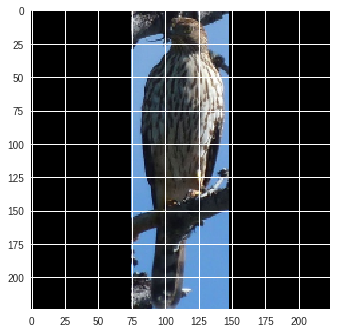

Prediction: 4 (Gray_Catbird)
Actual: 4 (Gray_Catbird)


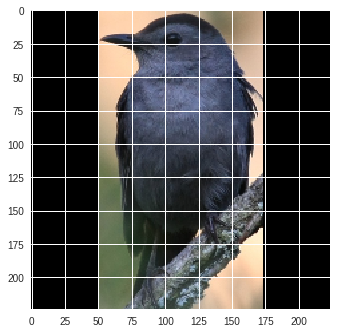

Prediction: 6 (Northern_Cardinal_(Female/Juvenile))
Actual: 6 (Northern_Cardinal_(Female/Juvenile))


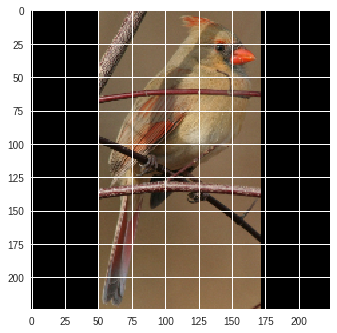

Prediction: 0 (Red-eyed_Vireo)
Actual: 0 (Red-eyed_Vireo)


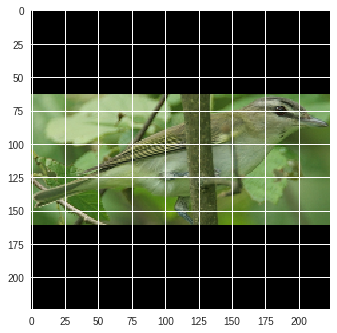

Prediction: 22 (Tufted_Titmouse)
Actual: 22 (Tufted_Titmouse)


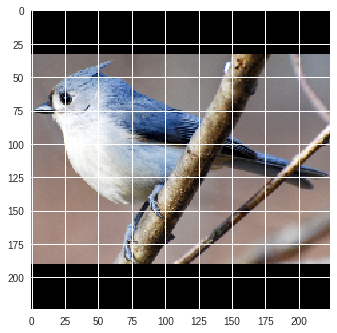

Prediction: 18 (Bushtit)
Actual: 13 (Northern_Mockingbird)


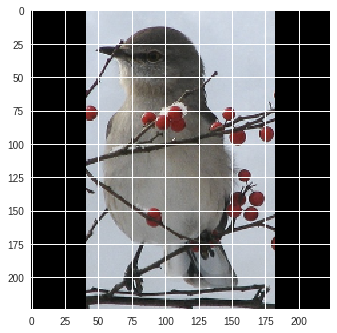

Prediction: 14 (Ring-billed_Gull_(Adult))
Actual: 14 (Ring-billed_Gull_(Adult))


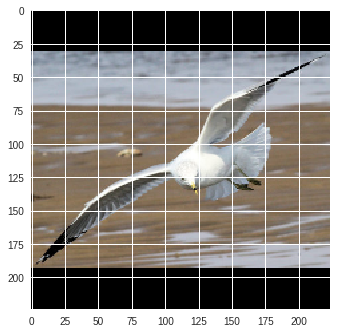

Prediction: 11 (Wilson's_Warbler)
Actual: 11 (Wilson's_Warbler)


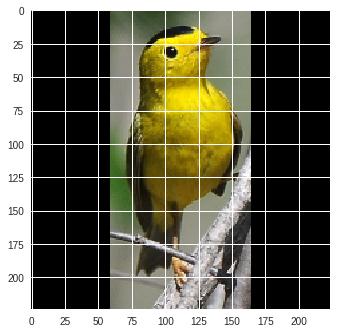

Prediction: 23 (Great-tailed_Grackle)
Actual: 23 (Great-tailed_Grackle)


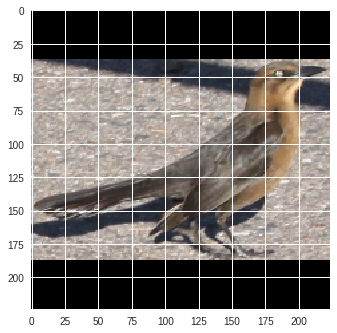

Prediction: 4 (Gray_Catbird)
Actual: 4 (Gray_Catbird)


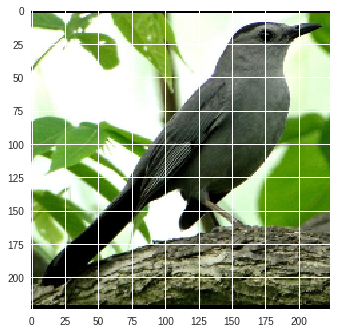

Prediction: 1 (Steller's_Jay)
Actual: 1 (Steller's_Jay)


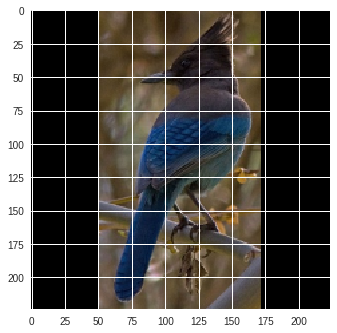

Prediction: 9 (Brown-headed_Cowbird_(Male))
Actual: 9 (Brown-headed_Cowbird_(Male))


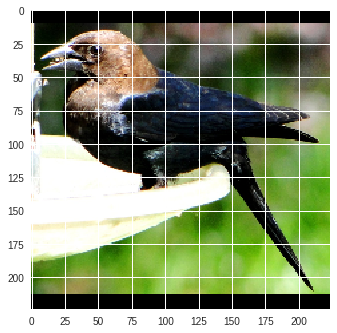

Prediction: 12 (Northern_Harrier_(Female,_immature))
Actual: 12 (Northern_Harrier_(Female,_immature))


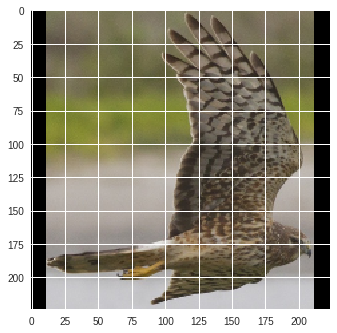

Prediction: 16 (Prairie_Warbler)
Actual: 16 (Prairie_Warbler)


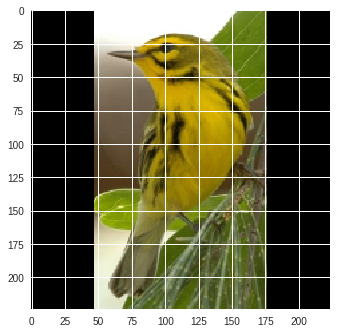

620
750


In [0]:
S_list = ['Osprey','White-Brested Nuthatch','Northern Cardinal'];
correct_prediction = 0
for ii in range(len(probs)):
    P_this = np.argmax(probs[ii])
    GT_this = y_test[ii]
    if P_this == GT_this:
        correct_prediction += 1
    if ii < 50:
        print("Prediction: {} ({})".format(P_this,L[P_this]))
        print("Actual: {} ({})".format(GT_this,L[GT_this]))
        plt.figure()
        plt.imshow(X_test[ii,:,:,:])
        plt.show()
print(correct_prediction)
print(len(probs))

In [0]:
L

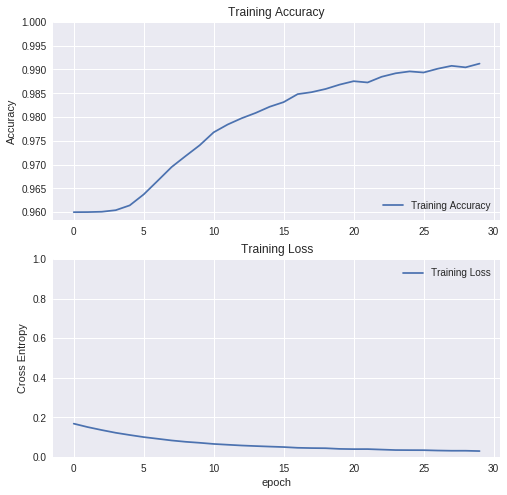

In [0]:
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                32025     
Total params: 2,290,009
Trainable params: 1,894,617
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
initial_epochs = 30
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs


def fit_model_FT(model, X_train, X_test, y_train, y_test, batch_size=32, epochs=10):
    generator = _image_generator(X_train, y_train)
    # Change learning rate when learning plateaus
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
              patience=4, min_lr=0.00001)

    # Stop model once it stops improving to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

    # put all callback functions in a list
    callbacks_list = [early_stop, reduce_lr]
    callbacks_list = [reduce_lr]
    
    history = model.fit(
        generator.flow(X_train, Y_train, batch_size=batch_size),
        steps_per_epoch=(X_train.shape[0] // batch_size),
        epochs=total_epochs,
        initial_epoch = initial_epochs,
        callbacks=None
        )
    score = model.evaluate(X_test, y_test, verbose=1)
    probs = model.predict(X_test, batch_size=batch_size)
    return model, score, probs, history

In [0]:
fit_model, score, probs, history = fit_model_FT(model, X_train, X_test, Y_train, Y_test, batch_size=32, epochs=15)


Epoch 31/45
70/70 [==============================] - 30s 426ms/step - loss: 0.0272 - accuracy: 0.9916
Epoch 32/45
70/70 [==============================] - 10s 148ms/step - loss: 0.0225 - accuracy: 0.9937
Epoch 33/45
70/70 [==============================] - 10s 146ms/step - loss: 0.0188 - accuracy: 0.9946
Epoch 34/45
70/70 [==============================] - 10s 147ms/step - loss: 0.0173 - accuracy: 0.9953
Epoch 35/45
70/70 [==============================] - 10s 148ms/step - loss: 0.0143 - accuracy: 0.9963
Epoch 36/45
70/70 [==============================] - 10s 146ms/step - loss: 0.0128 - accuracy: 0.9971
Epoch 37/45
70/70 [==============================] - 10s 148ms/step - loss: 0.0110 - accuracy: 0.9974
Epoch 38/45
70/70 [==============================] - 10s 147ms/step - loss: 0.0100 - accuracy: 0.9980
Epoch 39/45
70/70 [==============================] - 10s 148ms/step - loss: 0.0083 - accuracy: 0.9986
Epoch 40/45
70/70 [==============================] - 10s 148ms/step - loss: 0.0070

Prediction: 12 (Northern_Harrier_(Female,_immature))
Actual: 12 (Northern_Harrier_(Female,_immature))


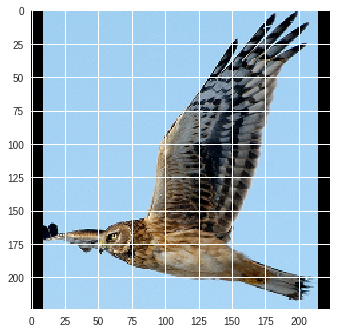

Prediction: 20 (Cooper's_Hawk_(Immature))
Actual: 20 (Cooper's_Hawk_(Immature))


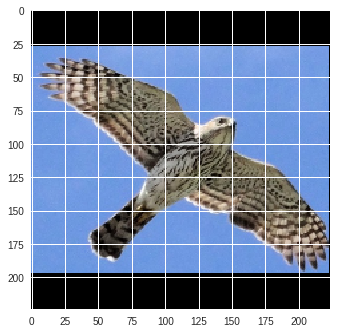

Prediction: 3 (Western_Meadowlark)
Actual: 3 (Western_Meadowlark)


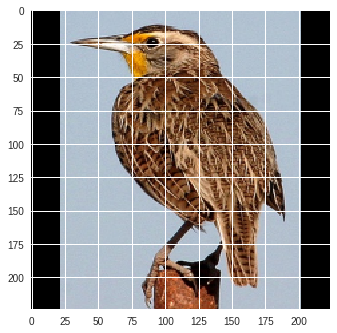

Prediction: 22 (Tufted_Titmouse)
Actual: 22 (Tufted_Titmouse)


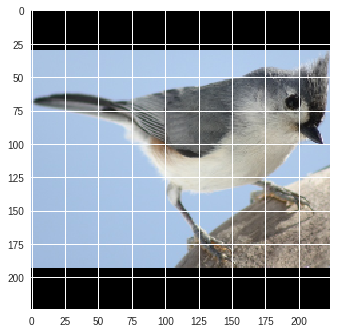

Prediction: 6 (Northern_Cardinal_(Female/Juvenile))
Actual: 6 (Northern_Cardinal_(Female/Juvenile))


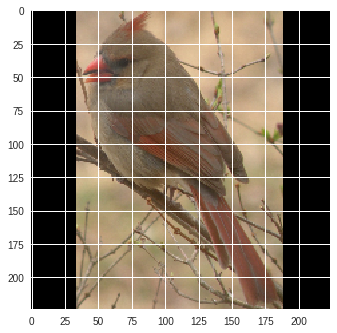

Prediction: 13 (Northern_Mockingbird)
Actual: 13 (Northern_Mockingbird)


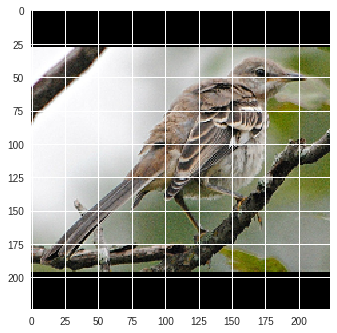

Prediction: 1 (Steller's_Jay)
Actual: 1 (Steller's_Jay)


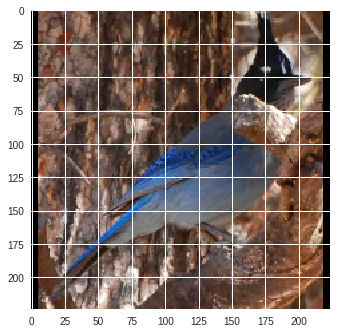

Prediction: 18 (Bushtit)
Actual: 18 (Bushtit)


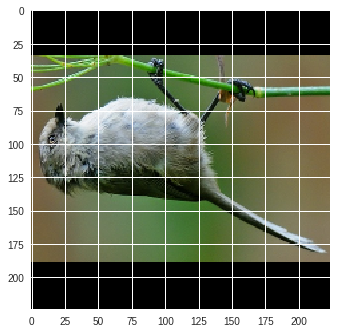

Prediction: 3 (Western_Meadowlark)
Actual: 3 (Western_Meadowlark)


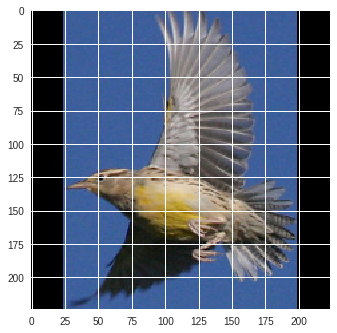

Prediction: 23 (Great-tailed_Grackle)
Actual: 23 (Great-tailed_Grackle)


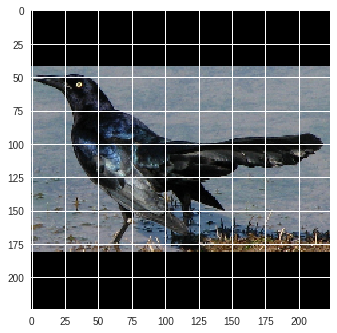

672
750


In [0]:
correct_prediction = 0
for ii in range(len(probs)):
    P_this = np.argmax(probs[ii])
    GT_this = y_test[ii]
    if P_this == GT_this:
        correct_prediction += 1
    if ii < 10:
        print("Prediction: {} ({})".format(P_this,L[P_this]))
        print("Actual: {} ({})".format(GT_this,L[GT_this]))
        plt.figure()
        plt.imshow(X_test[ii,:,:,:])
        plt.show()
print(correct_prediction)
print(len(probs))